# VIIRS Level 2 - Deep Blue Aerosol - AOI Processing and Visualization (Single-File)

## About

This notebook loads data from a single VIIRS Level 2 (e.g., AERDB_L2_VIIRS_NOAA20 or AERDB_L2_VIIRS_SNPP) NetCDF file, processes it for a user-defined Area of Interest (AOI), and performs the following:
1. Extracts latitude, longitude, Aerosol Optical Depth at 550nm, Quality Flags (Land & Ocean), and Aerosol Type.
2. Converts Scan Start Time (TAI93 seconds) to datetime objects.
3. Filters data for the specified AOI and good quality flags (AOD QA=2 'Moderate' or QA=3 'Good' from combined Land/Ocean flags).
4. Visualizes AOD and Aerosol Type maps for the AOI.
5. Saves one ASCII (CSV) file containing all individual good-quality pixel data (AOD, QA, Aerosol Type) within the AOI.

## Step 1: Load Python Libraries

In [1]:
import xarray as xr
import numpy as np
import os
import datetime

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches # Needed for creating legend handles

## Step 2: User Settings, AOI Definition, and File Specification

In [2]:
# --- User Settings --- #
viirs_single_file_path = '../data/viirs_aod/AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424.nc' # Specify your single file path

output_image_dir_viirs = '../output/images/' 
output_ascii_dir_viirs = '../output/ascii/'

# Define your Area of Interest (AOI)
lat_min_aoi = 7.0   
lat_max_aoi = 23.0
lon_min_aoi = 95.0
lon_max_aoi = 110.0

# Variable names (Ensure these match your specific VIIRS product)
# These are at the root level in AERDB_L2 products as per provided metadata
lat_var_name = 'Latitude' 
lon_var_name = 'Longitude' 
aod_var_name = 'Aerosol_Optical_Thickness_550_Land_Ocean' 
qa_land_var_name = 'Aerosol_Optical_Thickness_QA_Flag_Land' 
qa_ocean_var_name = 'Aerosol_Optical_Thickness_QA_Flag_Ocean' 
aer_type_var_name = 'Aerosol_Type_Land_Ocean' # Aerosol Type variable
time_coord_name = 'Scan_Start_Time' # 2D TAI93 seconds variable
# --- End User Settings --- #

os.makedirs(output_image_dir_viirs, exist_ok=True)
os.makedirs(output_ascii_dir_viirs, exist_ok=True)

base_output_filename_prefix = ""

if not os.path.exists(viirs_single_file_path):
    print(f"VIIRS NetCDF file not found: {viirs_single_file_path}")
    viirs_file_list = [] # Ensure file list is empty if file not found
else:
    viirs_file_list = [viirs_single_file_path] # For consistency with loop structure later
    print(f"Processing VIIRS file: {viirs_single_file_path}")
    base_output_filename_prefix = os.path.splitext(os.path.basename(viirs_single_file_path))[0] + "_AOI"

Processing VIIRS file: ../data/viirs_aod/AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424.nc


## Step 3: Load Data, Process, Clip to AOI

In [3]:
# Lists to store data for plotting (will hold data from the single granule)
latitude_all_granules_plot = []
longitude_all_granules_plot = []
aod_for_plot_all_granules = []
aer_type_for_plot_all_granules = [] # For aerosol type plot

# Lists for the ASCII file (all valid pixels within AOI)
ascii_pixels_datetime = []
ascii_pixels_lat = []
ascii_pixels_lon = []
ascii_pixels_aod = []
ascii_pixels_qf = []
ascii_pixels_aer_type = [] # For aerosol type in ASCII

var_attributes = {} 
any_file_processed_successfully = False
epoch_tai93 = datetime.datetime(1993, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)

if viirs_file_list: # This will be a list of one file if it exists
    file_path = viirs_file_list[0]
    print(f"\n--- Processing file: {os.path.basename(file_path)} ---")
    try:
        with xr.open_dataset(file_path, decode_cf=True, decode_timedelta=False) as ds_single:
            lat_granule_raw = ds_single[lat_var_name].data
            lon_granule_raw = ds_single[lon_var_name].data
            aod_granule_raw = ds_single[aod_var_name].data
            qa_land_granule_raw = ds_single[qa_land_var_name].data
            qa_ocean_granule_raw = ds_single[qa_ocean_var_name].data
            aer_type_granule_raw = ds_single[aer_type_var_name].data # Aerosol Type
            time_data_raw = ds_single[time_coord_name].data

            # Store attributes 
            var_attributes['AOD_long_name'] = ds_single[aod_var_name].attrs.get('long_name', aod_var_name)
            var_attributes['AOD_units'] = ds_single[aod_var_name].attrs.get('units', '1')
            var_attributes['AOD_fill_value'] = ds_single[aod_var_name].attrs.get('_FillValue', np.nan)
            var_attributes['QA_Land_fill_value'] = ds_single[qa_land_var_name].attrs.get('_FillValue', 0) # Per metadata _FillValue is 0
            var_attributes['QA_Ocean_fill_value'] = ds_single[qa_ocean_var_name].attrs.get('_FillValue', 0) # Per metadata _FillValue is 0
            var_attributes['Aer_Type_long_name'] = ds_single[aer_type_var_name].attrs.get('long_name', aer_type_var_name)
            var_attributes['Aer_Type_units'] = ds_single[aer_type_var_name].attrs.get('units', '1')
            var_attributes['Aer_Type_fill_value'] = ds_single[aer_type_var_name].attrs.get('_FillValue', -999) # As per metadata
            var_attributes['Lat_fill_value'] = ds_single[lat_var_name].attrs.get('_FillValue', np.nan)
            var_attributes['Lon_fill_value'] = ds_single[lon_var_name].attrs.get('_FillValue', np.nan)

            # Process AOD
            aod_fill = var_attributes['AOD_fill_value']
            aod_processed_granule = np.where(aod_granule_raw == aod_fill if not np.isnan(aod_fill) else np.isnan(aod_granule_raw), np.nan, aod_granule_raw)

            # Process and Combine QA Flags (Robust handling for potential NaNs before cast)
            qa_land_fill = var_attributes['QA_Land_fill_value'] 
            qa_ocean_fill = var_attributes['QA_Ocean_fill_value']
            
            qa_land_temp_float = np.array(qa_land_granule_raw, dtype=float)
            qa_land_temp_float_no_nan = np.where(np.isnan(qa_land_temp_float), -2.0, qa_land_temp_float) # Use -2 temporarily for NaNs
            qa_land_processed = np.where(qa_land_temp_float_no_nan == float(qa_land_fill), -1.0, qa_land_temp_float_no_nan).astype(np.int8)

            qa_ocean_temp_float = np.array(qa_ocean_granule_raw, dtype=float)
            qa_ocean_temp_float_no_nan = np.where(np.isnan(qa_ocean_temp_float), -2.0, qa_ocean_temp_float)
            qa_ocean_processed = np.where(qa_ocean_temp_float_no_nan == float(qa_ocean_fill), -1.0, qa_ocean_temp_float_no_nan).astype(np.int8)
            
            qa_combined_granule = np.full_like(aod_processed_granule, -1, dtype=np.int8) # Default to fill (-1)
            qa_combined_granule[qa_land_processed != -1] = qa_land_processed[qa_land_processed != -1]
            ocean_pixels_mask = (qa_combined_granule == -1) & (qa_ocean_processed != -1)
            qa_combined_granule[ocean_pixels_mask] = qa_ocean_processed[ocean_pixels_mask]

            # Process Aerosol Type (Robust handling)
            aer_type_fill = var_attributes['Aer_Type_fill_value'] # Should be -999
            aer_type_temp_float = np.array(aer_type_granule_raw, dtype=float)
            aer_type_temp_float_no_nan = np.where(np.isnan(aer_type_temp_float), -1.0, aer_type_temp_float)
            aer_type_processed_granule = np.where(aer_type_temp_float_no_nan == float(aer_type_fill), -1.0, aer_type_temp_float_no_nan).astype(np.int8)

            # Process Lat/Lon
            lat_fill = var_attributes['Lat_fill_value']
            lon_fill = var_attributes['Lon_fill_value']
            lat_granule = np.where(lat_granule_raw == lat_fill if not np.isnan(lat_fill) else np.isnan(lat_granule_raw), np.nan, lat_granule_raw)
            lon_granule = np.where(lon_granule_raw == lon_fill if not np.isnan(lon_fill) else np.isnan(lon_granule_raw), np.nan, lon_granule_raw)
            
            aoi_mask = (~np.isnan(lat_granule)) & (~np.isnan(lon_granule)) & \
                         (lat_granule >= lat_min_aoi) & (lat_granule <= lat_max_aoi) & \
                         (lon_granule >= lon_min_aoi) & (lon_granule <= lon_max_aoi)
            good_qa_mask = np.isin(qa_combined_granule, [2, 3]) # Filter using combined QA
            final_valid_mask = aoi_mask & good_qa_mask
            
            aod_for_plot_granule = np.where(final_valid_mask, aod_processed_granule, np.nan)
            aer_type_for_plot_granule = np.where(final_valid_mask, aer_type_processed_granule, np.nan) # NaN out invalid for plot
            
            latitude_all_granules_plot.append(lat_granule)
            longitude_all_granules_plot.append(lon_granule)
            aod_for_plot_all_granules.append(aod_for_plot_granule)
            aer_type_for_plot_all_granules.append(aer_type_for_plot_granule)

            if np.any(final_valid_mask):
                any_file_processed_successfully = True
            
            if time_data_raw.shape == lat_granule_raw.shape:
                time_pixel_granule = time_data_raw
            # Time_TAI93 is typically 1D (scanline), but Scan_Start_Time is 2D in AERDB L2
            elif time_data_raw.ndim == 1 and len(time_data_raw) == lat_granule_raw.shape[0]:
                 time_pixel_granule = np.repeat(time_data_raw[:, np.newaxis], lat_granule_raw.shape[1], axis=1)
            else:
                print(f"  Warning: {time_coord_name} shape {time_data_raw.shape} not directly compatible with lat shape {lat_granule_raw.shape}. Assigning NaNs.")
                time_pixel_granule = np.full_like(lat_granule_raw, np.nan, dtype=float)

            lats_to_save = lat_granule[final_valid_mask]
            lons_to_save = lon_granule[final_valid_mask]
            aod_to_save = aod_processed_granule[final_valid_mask]
            qf_to_save = qa_combined_granule[final_valid_mask]
            aer_type_to_save = aer_type_processed_granule[final_valid_mask]
            time_seconds_to_save = time_pixel_granule[final_valid_mask]
            
            for idx_save in range(len(lats_to_save)):
                time_val_seconds = time_seconds_to_save[idx_save]
                dt_obj = None
                if not np.isnan(time_val_seconds):
                    try:
                        dt_obj = epoch_tai93 + datetime.timedelta(seconds=float(time_val_seconds))
                    except (ValueError, TypeError):
                        dt_obj = None
                
                if dt_obj is not None:
                    ascii_pixels_datetime.append(dt_obj)
                    ascii_pixels_lat.append(lats_to_save[idx_save])
                    ascii_pixels_lon.append(lons_to_save[idx_save])
                    ascii_pixels_aod.append(aod_to_save[idx_save])
                    ascii_pixels_qf.append(qf_to_save[idx_save])
                    ascii_pixels_aer_type.append(aer_type_to_save[idx_save])

            print(f"  Data from {os.path.basename(file_path)} processed and AOI/QA filtered pixels collected.")
    except Exception as e:
        print(f"  Error processing file {file_path}: {e}")
        try:
            with xr.open_dataset(file_path, decode_cf=False) as ds_debug:
                variables_in_file = list(ds_debug.variables.keys())
                print(f"    Available variables: {variables_in_file}")
        except Exception as e_debug:
            print(f"    Could not list variables from file {file_path}: {e_debug}")

    if not any_file_processed_successfully:
        print("No data was successfully processed from the file.")
        # base_output_filename_prefix might be set with _AOI, but no data was found in AOI+QA.
        # We might want to indicate this in the filename, but for simplicity, let's stick to the plan.
        # The plotting/saving steps check any_file_processed_successfully anyway.
    else:
        print(f"\nFinished processing file.")
        # base_output_filename_prefix is already set in Step 2 for single file processed successfully
                
    print("Data loading and initial processing complete.")
else:
    print("File path is not set or file does not exist. Nothing to process.")


--- Processing file: AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424.nc ---
  Data from AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424.nc processed and AOI/QA filtered pixels collected.

Finished processing file.
Data loading and initial processing complete.


## Step 4: Define Map Extent (Based on AOI for Plotting)

In [4]:
map_extent_aoi_plot = None
if any_file_processed_successfully: 
    padding = 2.0 
    map_extent_aoi_plot = [lon_min_aoi - padding, lon_max_aoi + padding, 
                           lat_min_aoi - padding, lat_max_aoi + padding]
    print(f"Map extent for AOI plotting (with padding): {map_extent_aoi_plot}")
else:
    print("Cannot define map extent as no data was loaded.")

Map extent for AOI plotting (with padding): [93.0, 112.0, 5.0, 25.0]


## Step 5: Visualize and Save Clipped AOD and Aerosol Type Maps
Data is filtered for AOD QA=2 or 3 ('Moderate' or 'Good') and shown for the AOI.
Aerosol Type Land/Ocean: 0=Dust, 1=Smoke, 2=High altitude smoke, 3=Pyrocumulonimbus, 4=Non-smoke fine mode, 5=Mixed, 6=Background maritime, 7=Fine dominated.

AOI AOD Map saved to: ../output/images/AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424_AOI_AOD550_QA.png


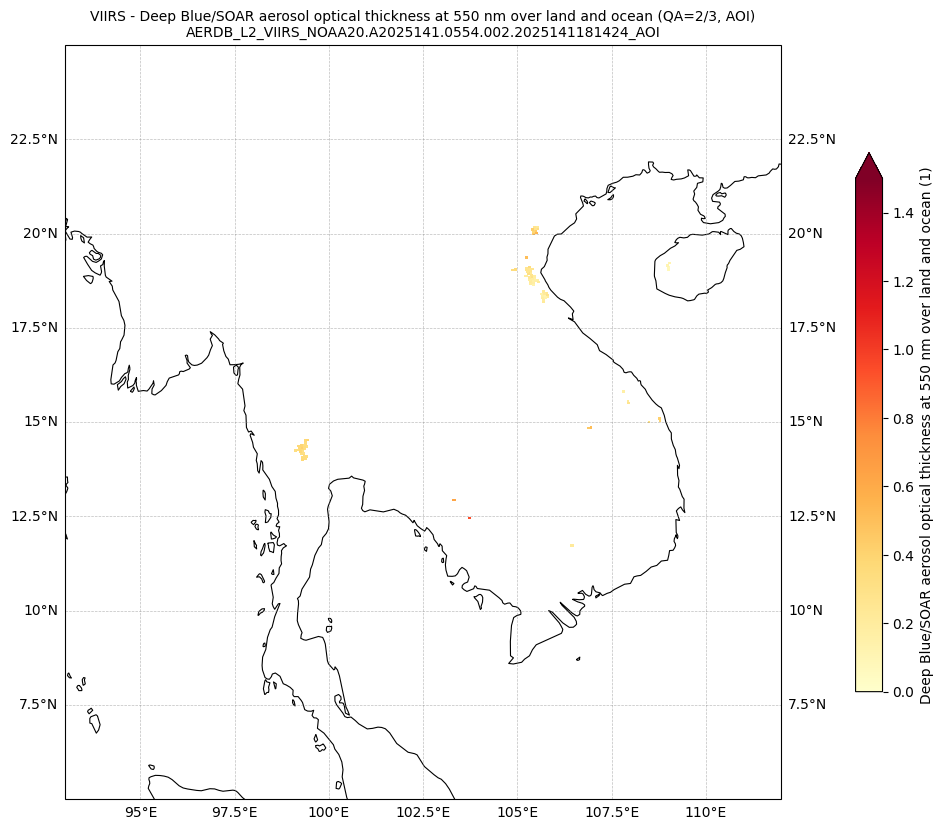

AOI Aerosol Type Map saved to: ../output/images/AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424_AOI_AerType_QA.png


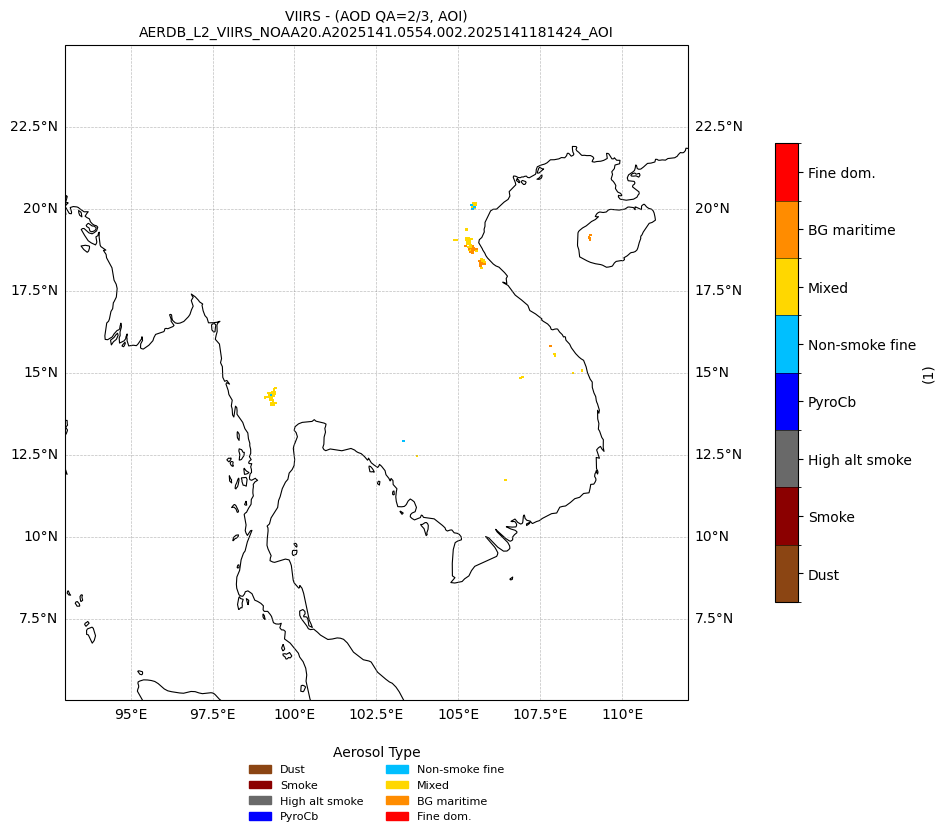

In [5]:
if any_file_processed_successfully and map_extent_aoi_plot is not None and aod_for_plot_all_granules:
    # --- Plot AOD Map ---
    fig_aod = plt.figure(figsize=(12, 10))
    ax_aod = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax_aod.set_extent(map_extent_aoi_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_aoi_plot}: {e}. Attempting to use granule extent or global.")
        if longitude_all_granules_plot and latitude_all_granules_plot and longitude_all_granules_plot[0].size > 0:
            lon_g_temp, lat_g_temp = longitude_all_granules_plot[0], latitude_all_granules_plot[0]
            ax_aod.set_extent([np.nanmin(lon_g_temp)-1, np.nanmax(lon_g_temp)+1, np.nanmin(lat_g_temp)-1, np.nanmax(lat_g_temp)+1], crs=ccrs.PlateCarree())
        else:
            ax_aod.set_global()

    ax_aod.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl_aod = ax_aod.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl_aod.top_labels = False; gl_aod.right_labels = True
    gl_aod.xformatter = LONGITUDE_FORMATTER; gl_aod.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_aod = None
    # Since it's a single file, latitude_all_granules_plot will have one element
    lon_g = longitude_all_granules_plot[0]
    lat_g = latitude_all_granules_plot[0]
    aod_g = aod_for_plot_all_granules[0]
    if aod_g.size > 0 and np.any(~np.isnan(aod_g)):
        plotted_mesh_aod = ax_aod.pcolormesh(lon_g, lat_g, aod_g, transform=ccrs.PlateCarree(), cmap='YlOrRd', vmin=0, vmax=1.5, shading='auto')
            
    aod_disp_long_name = var_attributes.get('AOD_long_name', 'AOD at 550nm')
    aod_disp_units = var_attributes.get('AOD_units', '1')
    title_aod = f'VIIRS - {aod_disp_long_name} (QA=2/3, AOI)\n{base_output_filename_prefix}'
    if plotted_mesh_aod:
        cbar_aod = plt.colorbar(plotted_mesh_aod, ax=ax_aod, orientation='vertical', pad=0.08, shrink=0.7, extend='max')
        cbar_aod.set_label(f"{aod_disp_long_name} ({aod_disp_units})")
        plt.title(title_aod, fontsize=10)
    else:
        print("No valid AOD data within AOI to plot.")
        plt.title(f'{title_aod}\nNo valid data in AOI from loaded file', fontsize=10)
        
    save_fn_aod = f"{base_output_filename_prefix}_AOD550_QA.png"
    full_save_path_aod = os.path.join(output_image_dir_viirs, save_fn_aod)
    plt.savefig(full_save_path_aod, dpi=300, bbox_inches='tight')
    print(f"AOI AOD Map saved to: {full_save_path_aod}")
    plt.show()
    plt.close(fig_aod)

    # --- Plot Aerosol Type Map ---
    fig_atype = plt.figure(figsize=(12, 10))
    ax_atype = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax_atype.set_extent(map_extent_aoi_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_aoi_plot}: {e}. Attempting to use granule extent or global.")
        if longitude_all_granules_plot and latitude_all_granules_plot and longitude_all_granules_plot[0].size > 0:
            lon_g_temp, lat_g_temp = longitude_all_granules_plot[0], latitude_all_granules_plot[0]
            ax_atype.set_extent([np.nanmin(lon_g_temp)-1, np.nanmax(lon_g_temp)+1, np.nanmin(lat_g_temp)-1, np.nanmax(lat_g_temp)+1], crs=ccrs.PlateCarree())
        else:
            ax_atype.set_global()
            
    ax_atype.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl_atype = ax_atype.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl_atype.top_labels = False; gl_atype.right_labels = True
    gl_atype.xformatter = LONGITUDE_FORMATTER; gl_atype.yformatter = LATITUDE_FORMATTER

    aerosol_labels_dict = { 
        0: 'Dust', 1: 'Smoke', 2: 'High alt smoke', 3: 'PyroCb', 
        4: 'Non-smoke fine', 5: 'Mixed', 6: 'BG maritime', 7: 'Fine dom.'
    } # Shortened labels for colorbar/legend
    fixed_colors = ['saddlebrown', 'darkred', 'dimgray', 'blue', 'deepskyblue', 'gold', 'darkorange', 'red']
    cmap_aer_type = mcolors.ListedColormap(fixed_colors[:len(aerosol_labels_dict)])
    bounds_plot = np.arange(len(aerosol_labels_dict) + 1) - 0.5
    norm_aer_type = mcolors.BoundaryNorm(boundaries=bounds_plot, ncolors=cmap_aer_type.N)
    ticks_plot = np.arange(len(aerosol_labels_dict))
    tick_labels_plot = [aerosol_labels_dict.get(i, f'Type {i}') for i in range(len(aerosol_labels_dict))]

    plotted_mesh_atype = None
    atype_g = aer_type_for_plot_all_granules[0]
    if atype_g.size > 0 and np.any(~np.isnan(atype_g)):
        # Use original lat/lon for pcolormesh, NaN where aerosol type is invalid
        plotted_mesh_atype = ax_atype.pcolormesh(lon_g, lat_g, atype_g, transform=ccrs.PlateCarree(), cmap=cmap_aer_type, norm=norm_aer_type, shading='auto')
    
    aer_type_disp_long_name = var_attributes.get('Aer_Type_long_name', 'Aerosol Type')
    title_atype = f'VIIRS - (AOD QA=2/3, AOI)\n{base_output_filename_prefix}'
    
    if plotted_mesh_atype:
        # Create custom legend handles
        legend_handles = [mpatches.Patch(color=cmap_aer_type(norm_aer_type(i)), label=aerosol_labels_dict.get(i, f'Type {i}'))
                          for i in sorted(aerosol_labels_dict.keys())]
        
        # Add the legend below the plot
        ax_atype.legend(handles=legend_handles, 
                        title="Aerosol Type", 
                        loc='lower center', 
                        bbox_to_anchor=(0.5, -0.2), # Position below the axis (0,0 is lower left)
                        ncol=2, 
                        fontsize=8,
                        frameon=False) # Optional: remove frame

        # Add colorbar
        cbar_atype = plt.colorbar(plotted_mesh_atype, ax=ax_atype, ticks=ticks_plot, orientation='vertical', pad=0.08, shrink=0.7, spacing='proportional', drawedges=True)
        cbar_atype.set_ticklabels(tick_labels_plot)
        cbar_atype.set_label(f"({var_attributes.get('Aer_Type_units', ' ')})")

        plt.title(title_atype, fontsize=10)
        fig_atype.tight_layout(rect=[0, 0.15, 1, 1]) # Adjust layout to make room for the legend

    else:
        plt.title(f'{title_atype}\nNo valid data in AOI', fontsize=10)

    save_fn_atype = f"{base_output_filename_prefix}_AerType_QA.png"
    full_save_path_atype = os.path.join(output_image_dir_viirs, save_fn_atype)
    plt.savefig(full_save_path_atype, dpi=300, bbox_inches='tight')
    print(f"AOI Aerosol Type Map saved to: {os.path.join(output_image_dir_viirs, save_fn_atype)}")
    plt.show()
    plt.close(fig_atype)
else:
    print("Skipping map plotting: No plottable data or map extent problem.")

## Step 6: Save Extracted Data to ASCII (CSV) File

In [6]:
# Save ASCII File: All valid pixels within AOI
if any_file_processed_successfully and ascii_pixels_datetime:
    ascii_pixels_filename = f"{base_output_filename_prefix}_pixels.csv"
    full_ascii_pixels_path = os.path.join(output_ascii_dir_viirs, ascii_pixels_filename)
    print(f"\nSaving all valid AOI pixel data to: {full_ascii_pixels_path}")
    with open(full_ascii_pixels_path, 'w') as f:
        f.write("Datetime,Latitude,Longitude,AOD_550_QAfilt,QualityFlag,AerosolType_QAfilt\n")
        for i in range(len(ascii_pixels_datetime)):
            dt_obj = ascii_pixels_datetime[i]
            lat_val = ascii_pixels_lat[i]
            lon_val = ascii_pixels_lon[i]
            aod_val = ascii_pixels_aod[i]
            qf_val = ascii_pixels_qf[i]
            aer_type_val = ascii_pixels_aer_type[i]
            dt_str = dt_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ')
            f.write(f"{dt_str},{lat_val:.4f},{lon_val:.4f},{aod_val:.4f},{int(qf_val)},{int(aer_type_val)}\n")
        print(f"Finished writing AOI pixel data. {len(ascii_pixels_datetime)} points written.")
else:
    print("Skipping ASCII file for AOI pixels: No valid data points processed.")


Saving all valid AOI pixel data to: ../output/ascii/AERDB_L2_VIIRS_NOAA20.A2025141.0554.002.2025141181424_AOI_pixels.csv
Finished writing AOI pixel data. 90 points written.


## End of Processing

In [7]:
print("VIIRS Single-File Data Processing Complete.")

VIIRS Single-File Data Processing Complete.
